# PaddleOCR with OpenVINO™

This demo shows how to run PP-OCR model on OpenVINO natively. Instead of exporting the PaddlePaddle model to ONNX and then converting to the OpenVINO Intermediate Representation (OpenVINO IR) format with model conversion API, you can now read directly from the PaddlePaddle Model without any conversions. [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR) is an ultra-light OCR model trained with PaddlePaddle deep learning framework, that aims to create multilingual and practical OCR tools.

The PaddleOCR pre-trained model used in the demo refers to the *"Chinese and English ultra-lightweight PP-OCR model (9.4M)"*. More open source pre-trained models can be downloaded at [PaddleOCR GitHub](https://github.com/PaddlePaddle/PaddleOCR) or [PaddleOCR Gitee](https://gitee.com/paddlepaddle/PaddleOCR). Working pipeline of the PaddleOCR is as follows:

<img align='center' src= "https://raw.githubusercontent.com/yoyowz/classification/master/images/pipeline.png" alt="drawing" width="1000"/>

> **NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server, the webcam will not work. You can still do inference on a video file.

<a id="0"></a>
Table of content:
- [Imports](#1)
    - [Select inference device](#2)
    - [Models for PaddleOCR](#3)
        - [Download the Model for Text **Detection**](#4)
        - [Load the Model for Text **Detection**](#5)
        - [Download the Model for Text **Recognition**](#6)
        - [Load the Model for Text **Recognition** with Dynamic Shape](#7)
    - [Preprocessing Image Functions for Text Detection and Recognition](#8)
    - [Postprocessing Image for Text Detection](#9)
    - [Main Processing Function for PaddleOCR](#10)
- [Run Live PaddleOCR with OpenVINO](#11)


In [ ]:
!pip install -q "openvino-dev>=2023.0.0"
!pip install paddleocr
!python -m pip install paddlepaddle-gpu==2.5.0.post118 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
!pip install -q "pyclipper>=1.2.1" "shapely>=1.7.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.1/466.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.2 MB/s eta 0:00:00
 

<a id="1"></a>
## Imports [&#8657;](#0)


In [ ]:
import sys
import cv2
import numpy as np
import paddle
import math
import time
import collections
from PIL import Image
from pathlib import Path
import tarfile

from openvino.runtime import Core
from IPython import display
import copy

/usr/local/lib/python3.10/dist-packages/paddle/fluid/framework.py:549: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(


In [ ]:
# Import local modules

utils_file_path = Path('../utils/notebook_utils.py')
notebook_directory_path = Path('.')

if not utils_file_path.exists():
    !git clone --depth 1 https://github.com/igor-davidyuk/openvino_notebooks.git -b moving_data_to_cloud openvino_notebooks
    utils_file_path = Path('./openvino_notebooks/notebooks/utils/notebook_utils.py')
    notebook_directory_path = Path('./openvino_notebooks/notebooks/405-paddle-ocr-webcam/')

sys.path.append(str(utils_file_path.parent))
sys.path.append(str(notebook_directory_path))

import notebook_utils as utils
import pre_post_processing as processing

fatal: destination path 'openvino_notebooks' already exists and is not an empty directory.


<a id="2"></a>
### Select inference device [&#8657;](#0)

select device from dropdown list for running inference using OpenVINO

In [ ]:
import ipywidgets as widgets

core = Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

<a id="3"></a>
### Models for PaddleOCR [&#8657;](#0)

PaddleOCR includes two parts of deep learning models, text detection and text recognition. Pre-trained models used in the demo are downloaded and stored in the "model" folder.

Only a few lines of code are required to run the model. First, initialize the runtime for inference. Then, read the network architecture and model weights from the `.pdmodel` and `.pdiparams` files to load to CPU/GPU.

In [ ]:
# Define the function to download text detection and recognition models from PaddleOCR resources.

def run_model_download(model_url: str, model_file_path: Path) -> None:
    """
    Download pre-trained models from PaddleOCR resources

    Parameters:
        model_url: url link to pre-trained models
        model_file_path: file path to store the downloaded model
    """
    archive_path = model_file_path.absolute().parent.parent / model_url.split("/")[-1]
    if model_file_path.is_file():
        print("Model already exists")
    else:
        # Download the model from the server, and untar it.
        print("Downloading the pre-trained model... May take a while...")

        # Create a directory.
        utils.download_file(model_url, archive_path.name, archive_path.parent)
        print("Model Downloaded")


        file = tarfile.open(archive_path)
        res = file.extractall(archive_path.parent)
        file.close()
        if not res:
            print(f"Model Extracted to {model_file_path}.")
        else:
            print("Error Extracting the model. Please check the network.")

<a id="4"></a>
#### Download the Model for Text **Detection** [&#8657;](#0)


In [ ]:
# A directory where the model will be downloaded.

det_model_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/paddle-ocr/ch_PP-OCRv3_det_infer.tar"
det_model_file_path = Path("model/ch_PP-OCRv3_det_infer/inference.pdmodel")

run_model_download(det_model_url, det_model_file_path)

Model already exists


<a id="5"></a>
#### Load the Model for Text **Detection** [&#8657;](#0)


In [ ]:
# Initialize OpenVINO Runtime for text detection.
core = Core()
det_model = core.read_model(model=det_model_file_path)
det_compiled_model = core.compile_model(model=det_model, device_name=device.value)

# Get input and output nodes for text detection.
det_input_layer = det_compiled_model.input(0)
det_output_layer = det_compiled_model.output(0)

<a id="6"></a>
#### Download the Model for Text **Recognition** [&#8657;](#0)


In [ ]:
rec_model_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/paddle-ocr/ch_PP-OCRv3_rec_infer.tar"
rec_model_file_path = Path("model/ch_PP-OCRv3_rec_infer/inference.pdmodel")

run_model_download(rec_model_url, rec_model_file_path)

Model already exists


<a id="7"></a>
#### Load the Model for Text **Recognition** with Dynamic Shape [&#8657;](#0)


Input to text recognition model refers to detected bounding boxes with different image sizes, for example, dynamic input shapes. Hence:

1. Input dimension with dynamic input shapes needs to be specified before loading text recognition model.
2. Dynamic shape is specified by assigning -1 to the input dimension or by setting the upper bound of the input dimension using, for example, `Dimension(1, 512)`.

In [ ]:
# Read the model and corresponding weights from a file.
rec_model = core.read_model(model=rec_model_file_path)

# Assign dynamic shapes to every input layer on the last dimension.
for input_layer in rec_model.inputs:
    input_shape = input_layer.partial_shape
    input_shape[3] = -1
    rec_model.reshape({input_layer: input_shape})

rec_compiled_model = core.compile_model(model=rec_model, device_name="AUTO")

# Get input and output nodes.
rec_input_layer = rec_compiled_model.input(0)
rec_output_layer = rec_compiled_model.output(0)

<a id="8"></a>
### Preprocessing Image Functions for Text Detection and Recognition [&#8657;](#0)


Define preprocessing functions for text detection and recognition:
1. Preprocessing for text detection: resize and normalize input images.
2. Preprocessing for text recognition: resize and normalize detected box images to the same size (for example, `(3, 32, 320)` size for images with Chinese text) for easy batching in inference.

In [ ]:
# Preprocess for text detection.
def image_preprocess(input_image, size):
    """
    Preprocess input image for text detection

    Parameters:
        input_image: input image
        size: value for the image to be resized for text detection model
    """
    img = cv2.resize(input_image, (size, size))
    img = np.transpose(img, [2, 0, 1]) / 255
    img = np.expand_dims(img, 0)
    # NormalizeImage: {mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225], is_scale: True}
    img_mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)

In [ ]:
# Preprocess for text recognition.
def resize_norm_img(img, max_wh_ratio):
    """
    Resize input image for text recognition

    Parameters:
        img: bounding box image from text detection
        max_wh_ratio: value for the resizing for text recognition model
    """
    rec_image_shape = [3, 48, 320]
    imgC, imgH, imgW = rec_image_shape
    assert imgC == img.shape[2]
    character_type = "ch"
    if character_type == "ch":
        imgW = int((32 * max_wh_ratio))
    h, w = img.shape[:2]
    ratio = w / float(h)
    if math.ceil(imgH * ratio) > imgW:
        resized_w = imgW
    else:
        resized_w = int(math.ceil(imgH * ratio))
    resized_image = cv2.resize(img, (resized_w, imgH))
    resized_image = resized_image.astype('float32')
    resized_image = resized_image.transpose((2, 0, 1)) / 255
    resized_image -= 0.5
    resized_image /= 0.5
    padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
    padding_im[:, :, 0:resized_w] = resized_image
    return padding_im


def prep_for_rec(dt_boxes, frame):
    """
    Preprocessing of the detected bounding boxes for text recognition

    Parameters:
        dt_boxes: detected bounding boxes from text detection
        frame: original input frame
    """
    ori_im = frame.copy()
    img_crop_list = []
    for bno in range(len(dt_boxes)):
        tmp_box = copy.deepcopy(dt_boxes[bno])
        img_crop = processing.get_rotate_crop_image(ori_im, tmp_box)
        img_crop_list.append(img_crop)

    img_num = len(img_crop_list)
    # Calculate the aspect ratio of all text bars.
    width_list = []
    for img in img_crop_list:
        width_list.append(img.shape[1] / float(img.shape[0]))

    # Sorting can speed up the recognition process.
    indices = np.argsort(np.array(width_list))
    return img_crop_list, img_num, indices


def batch_text_box(img_crop_list, img_num, indices, beg_img_no, batch_num):
    """
    Batch for text recognition

    Parameters:
        img_crop_list: processed detected bounding box images
        img_num: number of bounding boxes from text detection
        indices: sorting for bounding boxes to speed up text recognition
        beg_img_no: the beginning number of bounding boxes for each batch of text recognition inference
        batch_num: number of images for each batch
    """
    norm_img_batch = []
    max_wh_ratio = 0
    end_img_no = min(img_num, beg_img_no + batch_num)
    for ino in range(beg_img_no, end_img_no):
        h, w = img_crop_list[indices[ino]].shape[0:2]
        wh_ratio = w * 1.0 / h
        max_wh_ratio = max(max_wh_ratio, wh_ratio)
    for ino in range(beg_img_no, end_img_no):
        norm_img = resize_norm_img(img_crop_list[indices[ino]], max_wh_ratio)
        norm_img = norm_img[np.newaxis, :]
        norm_img_batch.append(norm_img)

    norm_img_batch = np.concatenate(norm_img_batch)
    norm_img_batch = norm_img_batch.copy()
    return norm_img_batch

<a id="9"></a>
### Postprocessing Image for Text Detection [&#8657;](#0)


In [ ]:
def post_processing_detection(frame, det_results):
    """
    Postprocess the results from text detection into bounding boxes

    Parameters:
        frame: input image
        det_results: inference results from text detection model
    """
    ori_im = frame.copy()
    data = {'image': frame}
    data_resize = processing.DetResizeForTest(data)
    data_list = []
    keep_keys = ['image', 'shape']
    for key in keep_keys:
        data_list.append(data_resize[key])
    img, shape_list = data_list

    shape_list = np.expand_dims(shape_list, axis=0)
    pred = det_results[0]
    if isinstance(pred, paddle.Tensor):
        pred = pred.numpy()
    segmentation = pred > 0.3

    boxes_batch = []
    for batch_index in range(pred.shape[0]):
        src_h, src_w, ratio_h, ratio_w = shape_list[batch_index]
        mask = segmentation[batch_index]
        boxes, scores = processing.boxes_from_bitmap(pred[batch_index], mask, src_w, src_h)
        boxes_batch.append({'points': boxes})
    post_result = boxes_batch
    dt_boxes = post_result[0]['points']
    dt_boxes = processing.filter_tag_det_res(dt_boxes, ori_im.shape)
    return dt_boxes

<a id="10"></a>
### Main Processing Function for PaddleOCR [&#8657;](#0)


Run `paddleOCR` function in different operations, either a webcam or a video file. See the list of procedures below:

1. Create a video player to play with target fps (`utils.VideoPlayer`).
2. Prepare a set of frames for text detection and recognition.
3. Run AI inference for both text detection and recognition.
4. Visualize the results.

In [ ]:
# Download font and a character dictionary for printing OCR results.
font_path = utils.download_file(
    url='https://raw.githubusercontent.com/Halfish/lstm-ctc-ocr/master/fonts/simfang.ttf',
    directory='fonts'
)
character_dictionary_path = utils.download_file(
    url='https://raw.githubusercontent.com/WenmuZhou/PytorchOCR/master/torchocr/datasets/alphabets/ppocr_keys_v1.txt',
    directory='fonts'
)

'fonts/simfang.ttf' already exists.


fonts/ppocr_keys_v1.txt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

In [ ]:
def load_image_with_orientation(image_path):
    img = Image.open(image_path)

    # Check if the image has Exif data with orientation information
    if hasattr(img, '_getexif'):
        exif = img._getexif()
        if exif is not None:
            orientation = exif.get(0x0112)
            # Orientation values: 1, 3, 6, 8 (See Exif documentation for details)
            if orientation == 3:
                img = img.rotate(180, expand=True)
            elif orientation == 6:
                img = img.rotate(270, expand=True)
            elif orientation == 8:
                img = img.rotate(90, expand=True)

    return img

In [ ]:
def get_results(frame):
    scale = 1280 / max(frame.shape)
    if scale < 1:
        frame = cv2.resize(src=frame, dsize=None, fx=scale, fy=scale,
                            interpolation=cv2.INTER_AREA)
    # Preprocess te image for text detection.
    test_image = image_preprocess(frame, 640)
    # Perform the inference step.
    det_results = det_compiled_model([test_image])[det_output_layer]
    dt_boxes = post_processing_detection(frame, det_results)

    dt_boxes = processing.sorted_boxes(dt_boxes)
    batch_num = 8
    img_crop_list, img_num, indices = prep_for_rec(dt_boxes, frame)

    rec_res = [['', 0.0]] * img_num
    txts = []
    scores = []

    for beg_img_no in range(0, img_num, batch_num):

        # Recognition starts from here.
        norm_img_batch = batch_text_box(
            img_crop_list, img_num, indices, beg_img_no, batch_num)

        # Run inference for text recognition.
        rec_results = rec_compiled_model([norm_img_batch])[rec_output_layer]

        # Postprocessing recognition results.
        postprocess_op = processing.build_post_process(processing.postprocess_params)
        rec_result = postprocess_op(rec_results)
        for rno in range(len(rec_result)):
            rec_res[indices[beg_img_no + rno]] = rec_result[rno]
        if rec_res:
            txts = [rec_res[i][0] for i in range(len(rec_res))]
            scores = [rec_res[i][1] for i in range(len(rec_res))]

    print(txts)
    return(txts, scores)

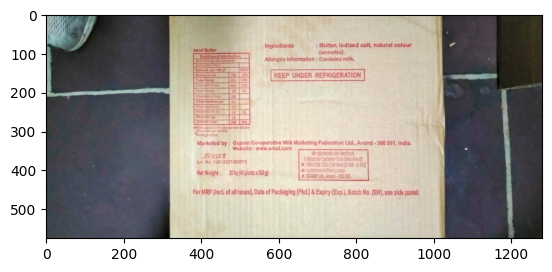

In [ ]:
img = np.array(load_image_with_orientation('/content/IMG-20230708-WA0064.jpg'))
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
t1 = time.time()
get_results(img)
t2 = time.time()
print(t2-t1)

['Ingredients', ':Butter,iodized salt, natural colour', 'AmulButter', '(annatto).', 'Nutritionalinfomation', 'Surngspercontain', 'AllergenInfomation:Containsmilk.', 'KEEPUNDERREFRIGERATION', 'Carohydratafe', 'WROA.standfotR', 'wanepetsetving', 'Majaiikin', 'Website:www.amul.com', 'Fsat', 'Weappreciateyourfeeback', 'Conatmer', 'Lio:No.10012021000071', '8', 'Neeigh0pecs', 'customercareamul.cop', 'GCHMMFdAnand3BB001', 'l']
1.021115779876709


In [ ]:
def run_paddle_ocr(source=0, flip=False, use_popup=False, skip_first_frames=0):
    """
    Main function to run the paddleOCR inference:
    1. Create a video player to play with target fps (utils.VideoPlayer).
    2. Prepare a set of frames for text detection and recognition.
    3. Run AI inference for both text detection and recognition.
    4. Visualize the results.

    Parameters:
        source: The webcam number to feed the video stream with primary webcam set to "0", or the video path.
        flip: To be used by VideoPlayer function for flipping capture image.
        use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
        skip_first_frames: Number of frames to skip at the beginning of the video.
    """
    # Create a video player to play with target fps.
    player = None
    try:
        player = utils.VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start video capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            start_time_1 = time.time()
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(src=frame, dsize=None, fx=scale, fy=scale,
                                   interpolation=cv2.INTER_AREA)
            # Preprocess the image for text detection.
            test_image = image_preprocess(frame, 640)

            # Measure processing time for text detection.
            start_time = time.time()
            # Perform the inference step.
            det_results = det_compiled_model([test_image])[det_output_layer]
            stop_time = time.time()

            # Postprocessing for Paddle Detection.
            dt_boxes = post_processing_detection(frame, det_results)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()
            processing_time_det = np.mean(processing_times) * 1000

            # Preprocess detection results for recognition.
            dt_boxes = processing.sorted_boxes(dt_boxes)
            batch_num = 6
            img_crop_list, img_num, indices = prep_for_rec(dt_boxes, frame)

            # For storing recognition results, include two parts:
            # txts are the recognized text results, scores are the recognition confidence level.
            rec_res = [['', 0.0]] * img_num
            txts = []
            scores = []

            for beg_img_no in range(0, img_num, batch_num):

                # Recognition starts from here.
                norm_img_batch = batch_text_box(
                    img_crop_list, img_num, indices, beg_img_no, batch_num)

                # Run inference for text recognition.
                rec_results = rec_compiled_model([norm_img_batch])[rec_output_layer]

                # Postprocessing recognition results.
                postprocess_op = processing.build_post_process(processing.postprocess_params)
                rec_result = postprocess_op(rec_results)
                for rno in range(len(rec_result)):
                    rec_res[indices[beg_img_no + rno]] = rec_result[rno]
                if rec_res:
                    txts = [rec_res[i][0] for i in range(len(rec_res))]
                    scores = [rec_res[i][1] for i in range(len(rec_res))]

            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            boxes = dt_boxes
            # Draw text recognition results beside the image.
            draw_img = processing.draw_ocr_box_txt(
                image,
                boxes,
                txts,
                scores,
                drop_score=0.5,
                font_path=str(font_path)
            )

            # Visualize the PaddleOCR results.
            f_height, f_width = draw_img.shape[:2]
            fps = 1000 / processing_time_det
            cv2.putText(img=draw_img, text=f"Inference time: {processing_time_det:.1f}ms ({fps:.1f} FPS)",
                        org=(20, 40),fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=f_width / 1000,
                        color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
            stop_time_1 = time.time()
            print("total inference time",stop_time_1-start_time_1)
            # Use this workaround if there is flickering.
            if use_popup:
                draw_img = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
                cv2.imshow(winname=title, mat=draw_img)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                draw_img = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
                _, encoded_img = cv2.imencode(ext=".jpg", img=draw_img,
                                              params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)

    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

<a id="11"></a>
## Run Live PaddleOCR with OpenVINO [&#8657;](#0)


Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

> **NOTE**: Popup mode may not work if you run this notebook on a remote computer.

Run live PaddleOCR:

In [ ]:
run_paddle_ocr(source=0, flip=False, use_popup=False)

Cannot open camera 0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If you do not have a webcam, you can still run this demo with a video file. Any [format supported by OpenCV](https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html) will work.

In [ ]:
# Test OCR results on a video file.

#video_file = "https://raw.githubusercontent.com/yoyowz/classification/master/images/test.mp4"
video_file = "/content/drive/MyDrive/crates1.mp4"
run_paddle_ocr(source=video_file, flip=False, use_popup=False, skip_first_frames=0)